In [3]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.tree import export_graphviz # tree 시각화를 위해
import graphviz # tree 시각화
from sklearn.metrics import f1_score# 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/LGaimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LGaimers/test.csv')

In [5]:
print(train_df.shape)
print(test_df.shape)

(598, 2881)
(310, 2879)


## 사용 함수 정의

In [6]:
# 모두 결측치인 변수 제거
def remove_all_nan(dataframe):
  col_list = dataframe.columns
  nan_list = []
  nan_cnt = []
  nan_col = []
  full_list = []

  for col in col_list:
    if dataframe[col].isnull().sum() == 0:
      full_list.append(col)
      continue
    nan_list.append([col,dataframe[col].isnull().sum()])
    nan_cnt.append(dataframe[col].isnull().sum())
    nan_col.append(col)

  del_col = []
  for nan in nan_list:
    if nan[1] == len(dataframe):
      del_col.append(nan[0])
  
  return dataframe.drop(columns=del_col)

In [7]:
'''값이 1개 존재하면 제거'''

def remove_one_value(dataframe):
  del_col = []
  col_list = dataframe.columns
  for col in col_list:
      if dataframe[col].nunique()==1 :
          del_col.append(col)
  
  return dataframe.drop(columns=del_col)

In [8]:
# iterativeimputer 함수 정의
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterativeimputer_subset(input_df,target_df,LINE_NUM):
  imputer = IterativeImputer(random_state=1234)

  cols = input_df.columns[:-1 * LINE_NUM]
  key_cols = input_df.columns[-1 * LINE_NUM:]

  total_subset = target_df[key_cols]
  interval = 100
  
  for i in range(0,len(cols)//interval):
    print(i,'번째 merge 진행중 ...')
    subset = pd.concat([input_df[key_cols], input_df[cols[i*interval : (i*interval)+interval]]], axis=1)
    imputer.fit(subset)

    target_subset = pd.concat([target_df[key_cols], target_df[cols[i*interval : (i*interval)+interval]]], axis=1)
    impute_subset = pd.DataFrame(imputer.transform(target_subset), columns=target_subset.columns)
    impute_subset = impute_subset.drop(key_cols,axis=1)

    print("기존 total : ", total_subset.shape, "기존 impute_subset : ", impute_subset.shape)
    total_subset = pd.concat([total_subset.reset_index(drop=True), impute_subset.reset_index(drop=True)], axis=1)
    print("병합 total : ", total_subset.shape)
    print('------------------------------------------------------')

  subset = pd.concat([input_df[key_cols], input_df[cols[total_subset.shape[1]-len(input_df.columns) : ]]], axis=1)
  imputer.fit(subset)

  target_subset = pd.concat([target_df[key_cols], target_df[cols[total_subset.shape[1]-len(input_df.columns) : ]]], axis=1)
  impute_subset = pd.DataFrame(imputer.transform(target_subset), columns=target_subset.columns)
  impute_subset = impute_subset.drop(key_cols,axis=1)

  print("기존 total : ", total_subset.shape, "기존 impute_subset : ", impute_subset.shape)
  total_subset = pd.concat([total_subset.reset_index(drop=True), impute_subset.reset_index(drop=True)], axis=1)
  print("병합 total : ", total_subset.shape)
  print('------------------------------------------------------')

  return total_subset

# LINE별 dataset 구축

In [9]:
train_T050304 = train_df[train_df['LINE'] == 'T050304']
train_T050307 = train_df[train_df['LINE'] == 'T050307']
train_T100304 = train_df[train_df['LINE'] == 'T100304']
train_T100306 = train_df[train_df['LINE'] == 'T100306']
train_T010306 = train_df[train_df['LINE'] == 'T010306']
train_T010305 = train_df[train_df['LINE'] == 'T010305']

In [10]:
test_T050304 = test_df[test_df['LINE'] == 'T050304']
test_T050307 = test_df[test_df['LINE'] == 'T050307']
test_T100304 = test_df[test_df['LINE'] == 'T100304']
test_T100306 = test_df[test_df['LINE'] == 'T100306']
test_T010306 = test_df[test_df['LINE'] == 'T010306']
test_T010305 = test_df[test_df['LINE'] == 'T010305']

In [11]:
print('train T050304 :' ,train_T050304['PRODUCT_CODE'].unique(), 'test T050304 :' ,test_T050304['PRODUCT_CODE'].unique())
print('train T050307 :' ,train_T050307['PRODUCT_CODE'].unique(), 'test T050307 :' ,test_T050307['PRODUCT_CODE'].unique())
print('train T100304 :' ,train_T100304['PRODUCT_CODE'].unique(), 'test T100304 :' ,test_T100304['PRODUCT_CODE'].unique())
print('train T100306 :' ,train_T100306['PRODUCT_CODE'].unique(), 'test T100306 :' ,test_T100306['PRODUCT_CODE'].unique())
print('train T010306 :' ,train_T010306['PRODUCT_CODE'].unique(), 'test T010306 :' ,test_T010306['PRODUCT_CODE'].unique())
print('train T010305 :' ,train_T010305['PRODUCT_CODE'].unique(), 'test T010305 :' ,test_T010305['PRODUCT_CODE'].unique())


train T050304 : ['A_31'] test T050304 : ['A_31']
train T050307 : ['A_31'] test T050307 : ['A_31']
train T100304 : ['T_31' 'O_31'] test T100304 : ['T_31' 'O_31']
train T100306 : ['T_31' 'O_31'] test T100306 : ['T_31' 'O_31']
train T010306 : ['A_31'] test T010306 : ['A_31']
train T010305 : ['A_31'] test T010305 : ['A_31']


In [12]:
train_T050304 = remove_all_nan(train_T050304)
train_T050307 = remove_all_nan(train_T050307)
train_T100304 = remove_all_nan(train_T100304)
train_T100306 = remove_all_nan(train_T100306)
train_T010306 = remove_all_nan(train_T010306)
train_T010305 = remove_all_nan(train_T010305)

In [13]:
train_T050304 = remove_one_value(train_T050304)
train_T050307 = remove_one_value(train_T050307)
train_T100304 = remove_one_value(train_T100304)
train_T100306 = remove_one_value(train_T100306)
train_T010306 = remove_one_value(train_T010306)
train_T010305 = remove_one_value(train_T010305)

In [14]:
train_T050304 = train_T050304.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])
train_T050307 = train_T050307.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])
train_T100304 = train_T100304.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])
train_T100306 = train_T100306.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])
train_T010306 = train_T010306.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])
train_T010305 = train_T010305.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Quality'])

In [15]:
train_T050304

,Y_Class,X_128,X_129,X_132,X_133,X_134,X_136,X_137,X_138,X_139,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870
0,1,7813.0,7813.0,0.19,0.2,0.19,228.0,228.0,225.0,582.9,...,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77
2,1,7815.0,7815.0,0.19,0.2,0.19,228.0,228.0,225.0,583.8,...,179.820690,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35
4,1,7817.0,7817.0,0.19,0.2,0.18,228.0,228.0,225.0,583.2,...,196.393333,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97
6,1,7820.0,7820.0,0.19,0.2,0.19,228.0,228.0,225.0,583.4,...,188.180000,176.9,384.0,368.425926,353.0,32.50,41.42,38.36,30.83,76.93
8,1,7822.0,7822.0,0.19,0.2,0.19,228.0,228.0,225.0,583.3,...,182.296667,173.8,393.0,373.500000,353.0,42.25,43.17,55.60,33.26,78.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0,11864.0,11864.0,0.19,0.2,0.19,230.0,230.0,230.0,584.0,...,183.833333,176.0,384.0,367.333333,352.0,NaN,NaN,NaN,NaN,NaN
582,0,11898.0,11898.0,0.18,0.2,0.18,230.0,230.0,230.0,583.3,...,198.366667,174.0,384.0,367.037037,352.0,50.88,53.23,52.44,56.28,66.83
583,0,11920.0,11920.0,0.19,0.2,0.19,230.0,230.0,230.0,583.5,...,191.993103,181.6,394.0,371.943396,353.0,51.71,59.64,54.61,57.05,63.18
594,0,14810.0,14810.0,0.19,0.2,0.19,304.0,304.0,304.0,588.9,...,180.810345,168.7,384.0,369.811321,353.0,49.47,53.07,50.89,55.10,66.49


## 변수 간 상관관계 파악 -> feature 줄이기

In [ ]:
train_T050304 = train_T050304.drop()

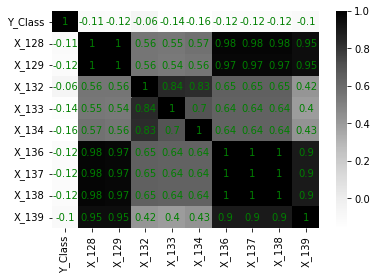

In [20]:
corr_df = train_T050304[train_T050304.columns[:10]]
corr_df = corr_df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

In [27]:
from collections import Counter
Counter(train_T050304['X_136'] != train_T050304['X_138'])

Counter({True: 25, False: 53})

In [28]:
train_T050304['X_138'].isnull().sum()

0

In [29]:
train_T050304_drop_cols = ['X_128','X_137']